In [ ]:
!apt-get install openjdk-8-jdk-headless
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
from pyspark.ml.clustering import *

print(dir())


['BisectingKMeans', 'BisectingKMeansModel', 'BisectingKMeansSummary', 'DistributedLDAModel', 'GaussianMixture', 'GaussianMixtureModel', 'GaussianMixtureSummary', 'In', 'KMeans', 'KMeansModel', 'KMeansSummary', 'LDA', 'LDAModel', 'LocalLDAModel', 'Out', 'PowerIterationClustering', 'SparkSession', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'exit', 'findspark', 'get_ipython', 'os', 'quit', 'spark']


In [ ]:
spark        


In [ ]:
#Load all datasets into spark
df_users = spark.read.csv("/content/users.csv", header=True, inferSchema=True)
df_userSession = spark.read.csv("/content/user-session.csv", header=True, inferSchema=True)
df_team = spark.read.csv("/content/team.csv", header=True, inferSchema=True)
df_teamAssignment = spark.read.csv("/content/team-assignments.csv", header=True, inferSchema=True)
df_levelEvents = spark.read.csv("/content/level-events.csv", header=True, inferSchema=True)
df_gameClicks = spark.read.csv("/content/game-clicks.csv", header=True, inferSchema=True)
df_buyClicks = spark.read.csv("/content/buy-clicks.csv", header=True, inferSchema=True)
df_adClicks = spark.read.csv("/content/ad-clicks.csv", header=True, inferSchema=True)
df_combined = spark.read.csv("/content/combined-data.csv", header=True, inferSchema=True)

In [ ]:
df_buyClicks.head(2)

[Row(timestamp='2016-05-26 15:36:54', txId=6004, userSessionId=5820, team=9, userId=1300, buyId=2, price=3.0),
 Row(timestamp='2016-05-26 15:36:54', txId=6005, userSessionId=5775, team=35, userId=868, buyId=4, price=10.0)]

In [ ]:
df_adClicks.head(2)

[Row(timestamp='2016-05-26 15:13:22', txId=5974, userSessionId=5809, teamId=27, userId=611, adId=2, adCategory='electronics'),
 Row(timestamp='2016-05-26 15:17:24', txId=5976, userSessionId=5705, teamId=18, userId=1874, adId=21, adCategory='movies')]

In [ ]:
df_gameClicks.head(2)

[Row(timestamp='2016-05-26 15:06:55', clickId=105, userId=1038, userSessionId=5916, isHit=0, teamId=25, teamLevel=1),
 Row(timestamp='2016-05-26 15:07:09', clickId=154, userId=1099, userSessionId=5898, isHit=0, teamId=44, teamLevel=1)]

In [ ]:
df_purchase = df_buyClicks[['userId','price']]
df_purchase.head(2)

[Row(userId=1300, price=3.0), Row(userId=868, price=10.0)]

In [ ]:
from pyspark.sql.functions import count
from pyspark.sql.functions import sum

# Group different attributes based on userId

gameclicks_peruser = df_gameClicks.groupBy('userId').agg(count('*').alias('gameclicks')).orderBy('userId')
gameclicks_peruser.show()
adclicks_peruser = df_adClicks.groupBy('userId').agg(count('*').alias('adclicks')).orderBy('userId')
adclicks_peruser.show()
revenue_peruser = df_buyClicks.groupBy('userId').agg(sum('price').alias('total_price')).orderBy('userId')
revenue_peruser.show()

In [ ]:
# Combine multiple dataframe

joined_df = gameclicks_peruser.join(adclicks_peruser, on='userId').join(revenue_peruser, on='userId')
joined_df.show(2)

+------+----------+--------+-----------+
|userId|gameclicks|adclicks|total_price|
+------+----------+--------+-----------+
|  1645|       977|      41|       16.0|
|   471|       524|      51|      202.0|
+------+----------+--------+-----------+
only showing top 2 rows



In [ ]:
#selecting columns which are necessary for clustering

df_cluster = joined_df.select('gameclicks', 'adclicks', 'total_price')

# Show the selected DataFrame
df_cluster.show(2)
num_rows = df_cluster.count()
num_cols = len(df_cluster.columns)
print('Shape:', (num_rows, num_cols))

+----------+--------+-----------+
|gameclicks|adclicks|total_price|
+----------+--------+-----------+
|       977|      41|       16.0|
|       524|      51|      202.0|
+----------+--------+-----------+
only showing top 2 rows

Shape: (543, 3)


**Kmeans clustering**

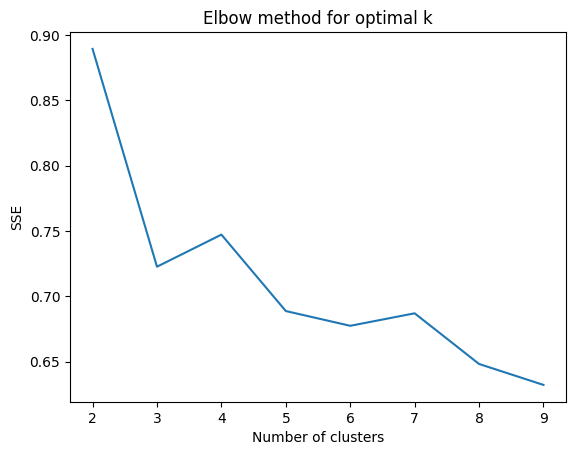

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

# Assuming 'df' is a Spark DataFrame with features in columns 'col1', 'col2', and 'col3'
# Create a VectorAssembler to combine the features into a single column called 'features'
assembler = VectorAssembler(inputCols=['adclicks', 'gameclicks', 'total_price'], outputCol='features')

# Transform the DataFrame using the VectorAssembler
df_transformed = assembler.transform(df_cluster)

# Evaluate clustering for different values of k
k_range = range(2, 10)
sse = []
for k in k_range:
    kmeans = KMeans().setK(k).setSeed(2)
    model = kmeans.fit(df_transformed)
    clustered = model.transform(df_transformed)
    evaluator = ClusteringEvaluator()
    sse.append(evaluator.evaluate(clustered))

# Plot the elbow curve
plt.plot(k_range, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method for optimal k')
plt.show()


In [ ]:
# Based on elbow method, number of clusters chosen is 3.

kmeans = KMeans().setK(3).setSeed(2)
model = kmeans.fit(df_transformed)

# Get the cluster centers
centroids = model.clusterCenters()
for i in centroids:
  print(i)
# Get the cluster assignments for each data point
clustered = model.transform(df_transformed)

# Show the results
clustered.show()

[ 36.44134078 926.11731844  46.96648045]
[  32.35555556 2310.64444444   39.42222222]
[ 24.98746082 357.95924765  35.06583072]
+----------+--------+-----------+------------------+----------+
|gameclicks|adclicks|total_price|          features|prediction|
+----------+--------+-----------+------------------+----------+
|       977|      41|       16.0| [41.0,977.0,16.0]|         0|
|       524|      51|      202.0|[51.0,524.0,202.0]|         2|
|      1103|      46|       22.0|[46.0,1103.0,22.0]|         0|
|       234|      17|        8.0|  [17.0,234.0,8.0]|         2|
|       678|      56|       14.0| [56.0,678.0,14.0]|         0|
|       481|      26|        8.0|  [26.0,481.0,8.0]|         2|
|       501|      39|       20.0| [39.0,501.0,20.0]|         2|
|       697|      16|       45.0| [16.0,697.0,45.0]|         0|
|       738|      44|       80.0| [44.0,738.0,80.0]|         0|
|       569|      41|       43.0| [41.0,569.0,43.0]|         2|
|       414|       3|        5.0|   [3.0,4

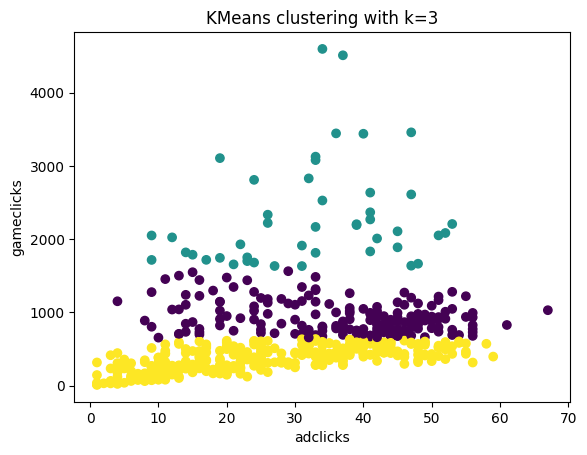

In [ ]:
# Extract the cluster assignments and the features from the DataFrame
clusters = clustered.select('prediction').rdd.flatMap(lambda x: x).collect()
features = df_transformed.rdd.map(lambda x: x.features).collect()
features
# Plot the clusters
plt.scatter([x[0] for x in features], [x[1] for x in features], c=clusters)
plt.xlabel('adclicks')
plt.ylabel('gameclicks')
plt.title('KMeans clustering with k=3')
plt.show()

In [ ]:
!pip install hdbscan


In [ ]:
df_cluster.head(1)

[Row(gameclicks=977, adclicks=41, total_price=16.0)]

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from pyspark.sql.functions import pandas_udf, PandasUDFType, monotonically_increasing_id
import pandas as pd

# define the agglomerative clustering function using pandas_udf
@pandas_udf("long", PandasUDFType.SCALAR)
def agg_clustering_udf(gameclicks: pd.Series, adclicks: pd.Series, total_price: pd.Series) -> pd.Series:
    # combine the input columns into a single pandas DataFrame
    pdf = pd.concat([gameclicks, adclicks, total_price], axis=1)

    # create the agglomerative clustering object
    n_clusters = 3
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

    # fit the data and obtain the resulting labels
    labels = agg_clustering.fit_predict(pdf)

    # return the labels as a pandas Series
    return pd.Series(labels)

# apply the agglomerative clustering function to the Spark DataFrame
df_cluster = df_cluster.repartition(1)  # ensure all data is in one partition
df_cluster = df_cluster.withColumn("id", monotonically_increasing_id())  # add a unique ID column
df_cluster = df_cluster.withColumn("cluster_id", agg_clustering_udf("adclicks", "gameclicks", "total_price"))
df_cluster = df_cluster.drop("features")  # remove the temporary features column

# show the resulting clustered DataFrame
df_cluster.show()


/content/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+----------+--------+-----------+---+----------+
|gameclicks|adclicks|total_price| id|cluster_id|
+----------+--------+-----------+---+----------+
|       711|      41|       16.0|  0|         2|
|       397|      51|      202.0|  1|         1|
|       827|      46|       22.0|  2|         2|
|        12|      17|        8.0|  3|         1|
|       513|      56|       14.0|  4|         1|
|       401|      26|        8.0|  5|         1|
|       351|      39|       20.0|  6|         1|
|       596|      44|       80.0|  7|         2|
|       439|      41|       43.0|  8|         1|
|      1135|      23|        3.0|  9|         2|
|       308|      25|       47.0| 10|         1|
|       425|      38|       27.0| 11|         1|
|       315|      49|      112.0| 12|         1|
|       342|      36|       13.0| 13|         1|
|       530|      19|        6.0| 14|         1|
|      1876|      52|       10.0| 15|         0|
|        41|      20|        2.0| 16|         1|
|      2729|      33

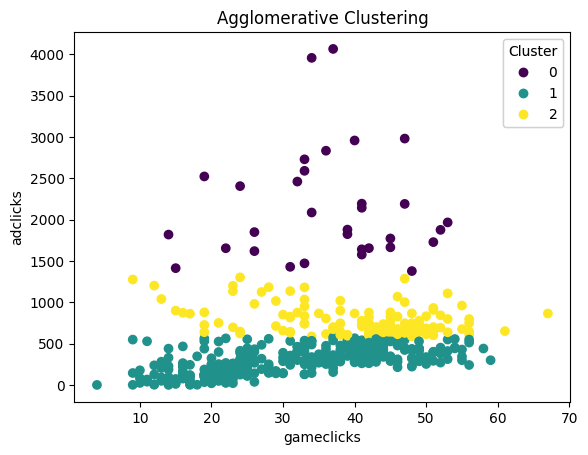

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pdf_cluster = df_cluster.toPandas()

# plot the results
fig, ax = plt.subplots()
scatter = ax.scatter( pdf_cluster['adclicks'],pdf_cluster['gameclicks'], c=pdf_cluster['cluster_id'], cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Cluster")
ax.add_artist(legend1)
plt.xlabel('gameclicks')
plt.ylabel('adclicks')
plt.title('Agglomerative Clustering')

plt.show()

**BKmeans clustering**


In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
#Find the optimal number of clusters using the silhouette method.
from pyspark.ml.feature import VectorAssembler
assemble=VectorAssembler(inputCols=['adclicks', 'gameclicks', 'total_price'],outputCol = 'features')

assembled_data=assemble.transform(df_cluster)
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
for K in range(2,11):

    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(assembled_data)

    BKMeans_transform=BKMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

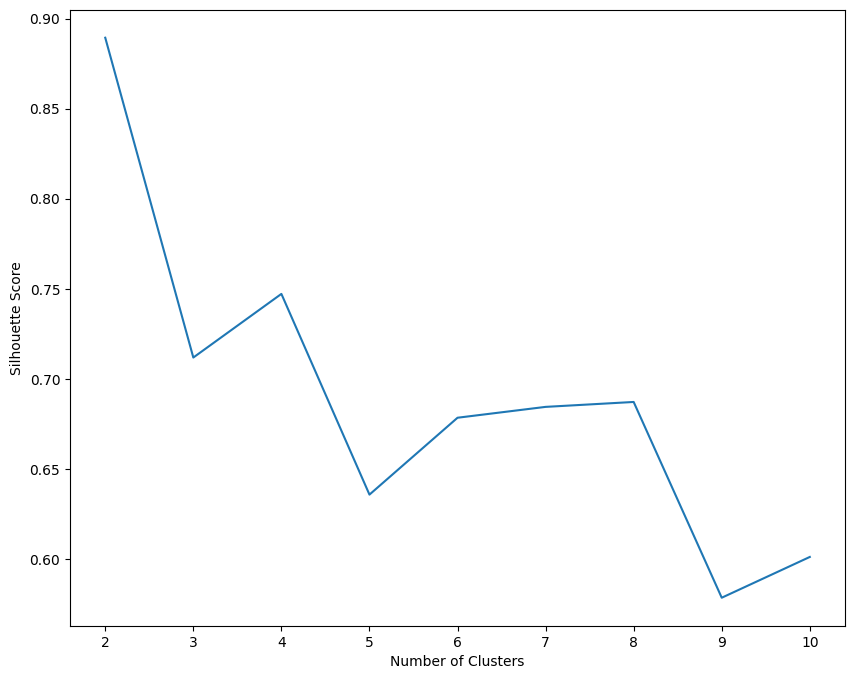

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

[ 24.85079365 354.46984127  35.14603175]
[ 37.17714286 893.73142857  47.37714286]
[  30.49056604 2186.45283019   37.83018868]
+----------+--------+-----------+------------------+----------+
|gameclicks|adclicks|total_price|          features|prediction|
+----------+--------+-----------+------------------+----------+
|       977|      41|       16.0| [41.0,977.0,16.0]|         1|
|       524|      51|      202.0|[51.0,524.0,202.0]|         0|
|      1103|      46|       22.0|[46.0,1103.0,22.0]|         1|
|       234|      17|        8.0|  [17.0,234.0,8.0]|         0|
|       678|      56|       14.0| [56.0,678.0,14.0]|         1|
|       481|      26|        8.0|  [26.0,481.0,8.0]|         0|
|       501|      39|       20.0| [39.0,501.0,20.0]|         0|
|       697|      16|       45.0| [16.0,697.0,45.0]|         1|
|       738|      44|       80.0| [44.0,738.0,80.0]|         1|
|       569|      41|       43.0| [41.0,569.0,43.0]|         0|
|       414|       3|        5.0|   [3.0,4

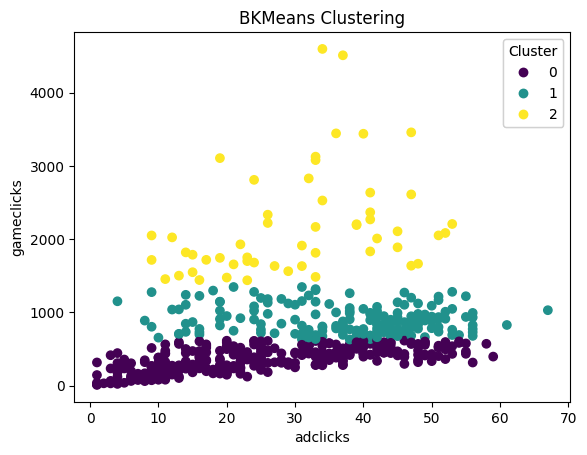

In [ ]:
## Based on elbow method, number of clusters chosen is 3.

BKMeans_=BisectingKMeans(featuresCol='features', k=3) 
BKMeans_Model=BKMeans_.fit(assembled_data)
centroids = BKMeans_Model.clusterCenters()
for i in centroids:
  print(i)
BKMeans_transform=BKMeans_Model.transform(assembled_data)

clustered = BKMeans_Model.transform(assembled_data)

# Show the results
clustered.show()
# Extract the cluster assignments and the features from the DataFrame
clusters = clustered.select('prediction').rdd.flatMap(lambda x: x).collect()
features = assembled_data.rdd.map(lambda x: x.features).collect()
features
# Plot the clusters
import pandas as pd
import matplotlib.pyplot as plt
clustered_df = clustered.select('adclicks', 'gameclicks', 'prediction').toPandas()

# plot the results
fig, ax = plt.subplots()
scatter = ax.scatter( clustered_df['adclicks'],clustered_df['gameclicks'], c=clustered_df['prediction'], cmap='viridis')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Cluster")
ax.add_artist(legend1)
plt.xlabel('adclicks')
plt.ylabel('gameclicks')
plt.title('BKMeans Clustering')

plt.show()